<h1>Анализ поведения пользователей в мобильном приложении<span class="tocSkip"></span></h1>  

Материалы:
* [Презентация] (https://drive.google.com/file/d/12Dsyyn-WTsTg5Z0H1c-v_RTzJPyK_Od7/view?usp=sharing)
* [Дашборд] (https://public.tableau.com/app/profile/dasha1951/viz/mobile_data/sheet3?publish=yes)

1. Предобработка данных  
    1.1  Изучение данных из файлов  
    1.2  Обработка пропусков  
    1.3  Замена типа данных  
    1.4  Обработка дубликатов  


2. Работа с метриками и бизнес-показателями  
    2.1  DAU/WAU  
    2.2  Retention Rate  


3. Исследовательский анализ данных  
    3.1  Разбивка пользователей по источникам  
    3.1  Анализ действий пользователей  
    3.3  Расчет конверсии действий пользователей в целевое событие  


4. Проверка гипотез  
    4.1  Гипотеза №1  
    4.2  Гипотеза №2  

5. Выводы и рекомендации  

**Задача:**    

Необходимо провести анализ поведения пользователей приложения по продаже товаров, с целью получения инсайтов и улучшения качества сервиса, а именно:


-	проанализировать связь целевого события (просмотра контактов) и других действий пользователей;
-	оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import math as mth

sns.set(rc={'figure.figsize':(10, 6)})

### Изучение данных из файлов

**Датасет mobile**

In [2]:
mobile.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
mobile.rename(columns={'event.time': 'event_time', 
                       'event.name': 'event_name', 
                       'user.id': 'user_id'}, inplace=True)

In [4]:
mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Проверим все ли идентификаторы были уникальны.

In [5]:
print(f'Всего строк - {len(mobile)} \nУникальных идентификаторов - {mobile["user_id"].nunique()}')

Всего строк - 74197 
Уникальных идентификаторов - 4293


Все пользователи уникальны.

**Датасет sources**

In [6]:
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [7]:
sources.rename(columns={'userId': 'user_id', 'source': 'source'}, inplace=True)

In [8]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Проверим все ли идентификаторы были уникальны.

In [9]:
print(f'Всего строк - {len(sources)} \nУникальных идентификаторов - {sources["user_id"].nunique()}')

Всего строк - 4293 
Уникальных идентификаторов - 4293


Все пользователи уникальны.

Проверим совпадают ли идентификаторы в двух датасетах:

In [10]:
if set(mobile['user_id']) == set(sources['user_id']):
    print('Множества идентификаторов в датасетах mobile и sources совпадают')
else:
    print('Множества идентификаторов в датасетах mobile и sources не совпадают')

Множества идентификаторов в датасетах mobile и sources совпадают


### Обработка пропусков

In [11]:
mobile.isnull().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [12]:
sources.isnull().sum()

user_id    0
source     0
dtype: int64

Пропущенных значений нет.

### Замена типа данных

Переведем данные в столбце `event_time` в формат datetime.

In [13]:
mobile['event_time'] = mobile['event_time'].astype('datetime64')
mobile['event_date'] = mobile['event_time'].dt.date.astype('datetime64')

Приведем данные в столбцах `event_name` и `source` к типу category. 

In [14]:
mobile['event_name'] = mobile['event_name'].astype('category')
sources['source'] = sources['source'].astype('category')

### Обработка дубликатов

In [15]:
mobile = mobile.drop_duplicates().reset_index(drop=True)
sources = sources.drop_duplicates().reset_index(drop=True)
print(mobile.duplicated().sum())
print(sources.duplicated().sum())

0
0


Дубликатов нет.

Для удобства дальнейшей работы объединим датасеты mobile и soures.

In [16]:
data = mobile.merge(sources, on='user_id', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  category      
 2   user_id     74197 non-null  object        
 3   event_date  74197 non-null  datetime64[ns]
 4   source      74197 non-null  category      
dtypes: category(2), datetime64[ns](2), object(1)
memory usage: 2.4+ MB


In [17]:
data.head()

,event_time,event_name,user_id,event_date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex


**Вывод по разделу:**  

Мы загрузили данные, проверили датасеты на предмет пропущенных значений и дубликатов (их нет). Для удобства дальнейшей работы переименовали столбцы и объединили датасеты, также теперь все столбцы имеют соответствующий своему значению тип данных.

## Работа с метриками и бизнес-показателями

Обозначим временные рамки исследования.

In [18]:
data['event_time'].describe().to_frame()

,event_time
count,74197
unique,74197
top,2019-10-19 18:36:07.773802
freq,1
first,2019-10-07 00:00:00.431357
last,2019-11-03 23:58:12.532487


In [19]:
print('Период наблюдения:',(mobile['event_time'].max() - mobile['event_time'].min()))

Период наблюдения: 27 days 23:58:12.101130


Почти 28 дней. 

### DAU/WAU

Вычислим среднее количество уникальных пользователей в день и в неделю за весь исследуемый период.

In [20]:
data['session_year'] = data['event_time'].dt.year
data['session_month'] = data['event_time'].dt.month
data['session_week'] = data['event_time'].dt.week
data['session_date'] = data['event_time'].dt.date

dau_total = data.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau_total = data.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).mean()

print('В день сервисом в среднем пользуется {} человек'.format(int(dau_total)))
print('В неделю сервисом в среднем пользуются {} человека'.format(int(wau_total)))

В день сервисом в среднем пользуется 279 человек
В неделю сервисом в среднем пользуются 1382 человека


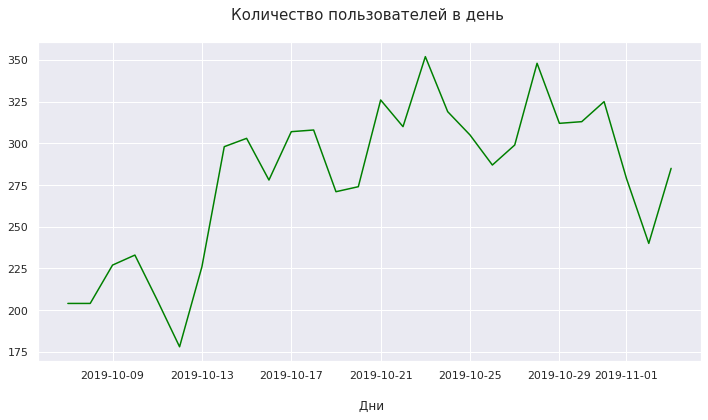

In [21]:
dau = data.groupby('session_date').agg({'user_id': 'nunique'}).plot(color = 'green')
 
plt.title('Количество пользователей в день \n', fontsize=15)
plt.xlabel('\n Дни')
plt.tight_layout()
plt.legend().remove()
plt.show()

Наибольшее количество пользователей зафиксировано 23 и 28 октября, а наименьшее 12 октября (показатель совсем низкий, скорее всего в этот день в приложении были технические неполадки). 

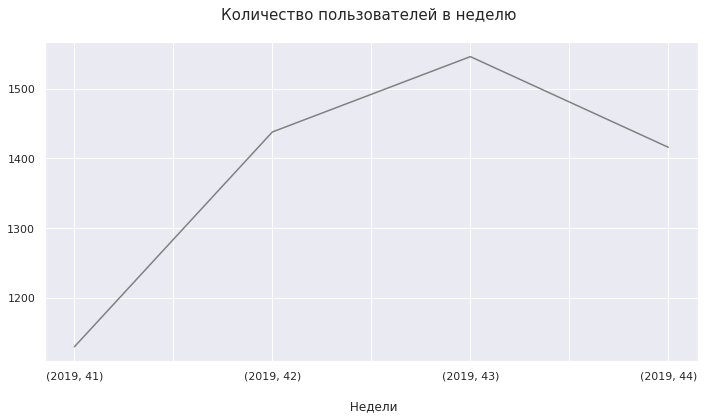

In [22]:
wau = data.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).plot(color = 'grey')
 
plt.title('Количество пользователей в неделю \n', fontsize=15)
plt.xlabel('\n Недели')
plt.tight_layout()
plt.legend().remove()
plt.show()

41-я неделя 2019 года: понедельник, 7 октября 2019 — воскресенье, 13 октября 2019  
42-я неделя 2019 года: понедельник, 14 октября 2019 — воскресенье, 20 октября 2019  
43-я неделя 2019 года: понедельник, 21 октября 2019 — воскресенье, 27 октября 2019

График иллюстрирует уверенный рост количества пользователей с 7 по 21 октября и постепенное снижение после 21 октября. Вероятно мы имеем дело с сезонным спросом (теплые вещи, зимняя резина, техника и товары для дома).

### Retention Rate

Найдем коэффициент удержания при помощи когортного анализа.  
Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность в приложении. Эти данные запишем в переменную first_session_date. Объединим ее с датафреймом data. Определим для каждой строки датафрейма lifetime пользователя в рамках когорты. 

In [23]:
data['week_date'] = data['event_date'] - pd.to_timedelta(data['event_date'].dt.dayofweek, unit = 'd')
first_session_date = data.groupby('user_id')['week_date'].min()
first_session_date.name = 'first_session_week'
raw_data = data.join(first_session_date, on='user_id')
raw_data['cohort_lifetime'] = raw_data['week_date'] - raw_data['first_session_week']
raw_data['cohort_lifetime'] = raw_data['cohort_lifetime'] / np.timedelta64(1,'W')
raw_data['cohort_lifetime'] = raw_data['cohort_lifetime'].round().astype('int')
raw_data.tail(3)

,event_time,event_name,user_id,event_date,source,session_year,session_month,session_week,session_date,week_date,first_session_week,cohort_lifetime
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,2019-11-03,google,2019,11,44,2019-11-03,2019-10-28,2019-10-21,1
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,google,2019,11,44,2019-11-03,2019-10-28,2019-10-14,2
74196,2019-11-03 23:58:12.532487,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,google,2019,11,44,2019-11-03,2019-10-28,2019-10-14,2


Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни». Получим число пользователей, изначально бывших в когорте, и на него разделим число пользователей в каждую следующую неделю. Найдём исходное количество пользователей в когорте, возьмём их число на нулевую неделю. Объединим данные по когортам с исходным количеством пользователей в когорте.  
Рассчитаем `Retention Rate`, разделив количество активных пользователей в каждую из недель на исходное число пользователей в когорте.

In [24]:
cohorts = (
    raw_data.groupby(['first_session_week', 'cohort_lifetime']).agg({'user_id': 'nunique'}).reset_index())

initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_week', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_session_week')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

cohorts.tail(3)

,first_session_week,cohort_lifetime,user_id,cohort_users,retention
7,2019-10-21,0,1094,1094,1.000000
8,2019-10-21,1,239,1094,0.218464
9,2019-10-28,0,903,903,1.000000


Построим сводную таблицу и создадим тепловую карту.

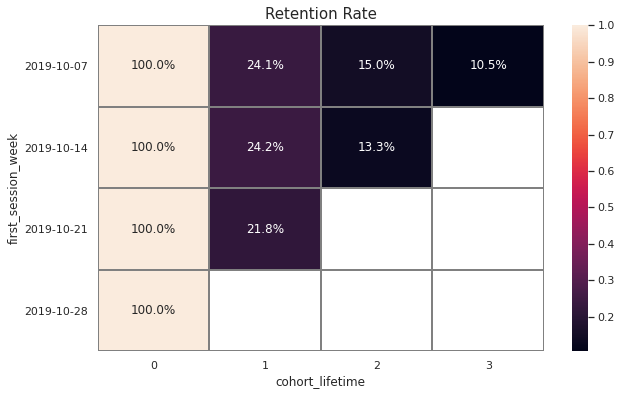

In [25]:
cohorts['first_session_week'] = cohorts['first_session_week'].dt.strftime('%Y-%m-%d')

retention_pivot = cohorts.pivot_table(
    index='first_session_week', columns='cohort_lifetime', values='retention', aggfunc='sum')

sns.set(style='white')
plt.title('Retention Rate', fontsize=15)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.yticks(rotation=0) 
plt.show()

Посмотрим, как изменялась со временем численность когорт.

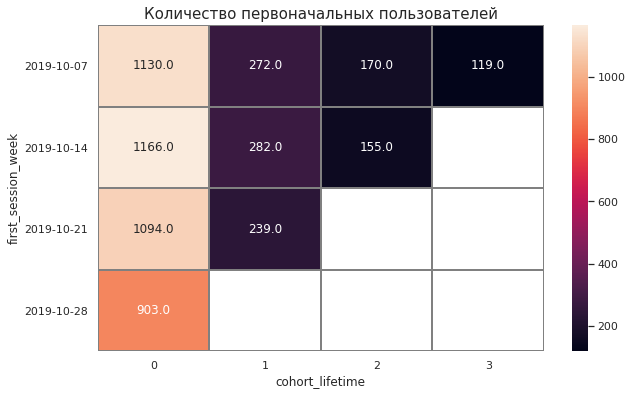

In [26]:
retention_pivot = cohorts.pivot_table(
    index='first_session_week', columns='cohort_lifetime', values='user_id', aggfunc='sum')

sns.set(style='white')
plt.title('Количество первоначальных пользователей', fontsize=15)
sns.heatmap(retention_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.yticks(rotation=0) 
plt.show()

Тепловые карты показывают сильное снижение коэффициента удержания для всех когорт, среднее значение на вторую неделю жизни составляет 23.4%. Причинами снижения могут быть технические проблемы со скоростью загрузки и работоспособностью или неудобная навигация (эти предположения стоит проверить). С другой стороны, пpoдaть или приобрести вeщи мoжнo и в дeнь paзмeщeния, ecли пoдoйти к пpoцeccy oтвeтcтвeннo. Объявления с качественными фотографиями, описанием и адекватной ценой закрываются как раз в пределах недели. 

**Вывод по разделу:**  

Мы начали исследование с расчета метрик количества уникальных пользователей в день и в неделю, так как в первую очередь на показатели активности влияет количество новых пользователей – чем их больше, и чем быстрее и стабильнее они приходят в приложение, тем быстрее растет аудитория. Расчет метрик DAU/WAU позволил выдвинуть предположение о наличии сезонной активности пользователей. 

Однако рассчитав коэффициент удержания мы обнаружили, что на вторую неделю жизни с нами остается только 23.4% пользователей. Снижение может быть вызвано как техническими проблемами, так и неудовлетворением спроса пользователей.

## Исследовательский анализ данных

### Разбивка пользователей по источникам   

Посмотрим какой из источников поставляет больше всего пользователей:

In [27]:
sources = data.groupby('source').nunique()
sources['user_id'].to_frame().sort_values(by='user_id', ascending=False).reset_index()

,source,user_id
0,yandex,1934
1,other,1230
2,google,1129


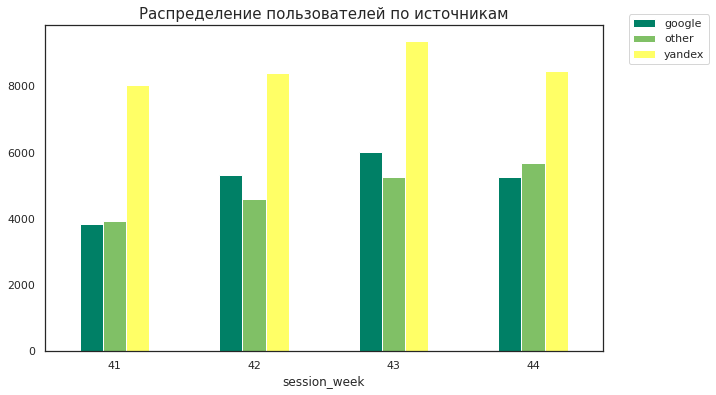

In [28]:
source_pivot = data.pivot_table(index='session_week', 
                               columns='source', 
                               values='user_id', 
                               aggfunc='count')

source_pivot.plot(kind='bar', cmap='summer')
plt.title('Распределение пользователей по источникам', fontsize=15)
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.xticks(rotation=0) 
plt.show()

Наибольшее число пользователей установили приложение при помощи yandex (1934), google и другие источники идут практически вровень(1129 и 1230 соответственно). График иллюстрирует уверенный рост числа пользователей по всем источникам в первые три недели наблюдения, в последнюю неделю  снижение для yandex и google, а для остальных источников стабильный рост. 

### Анализ действий пользователей

In [29]:
print('Количество уникальных пользователей:', data['user_id'].nunique())
print('Общее число событий:', data['event_name'].count())

Количество уникальных пользователей: 4293
Общее число событий: 74197


Среднее число входов в приложение на одного пользователя в день:

In [30]:
sessions_per_user = data.groupby(['session_month', 
                                  'session_week']).agg({'user_id': ['count','nunique']})

sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users']).round(2)
sessions_per_user['n_sessions_per_day'] = (sessions_per_user['n_sessions'] / 7).round()
sessions_per_user.reset_index()

,session_month,session_week,n_sessions,n_users,sessions_per_user,n_sessions_per_day
0,10,41,15822,1130,14.00,2260.0
1,10,42,18323,1438,12.74,2618.0
2,10,43,20636,1546,13.35,2948.0
3,10,44,12125,962,12.60,1732.0
4,11,44,7291,665,10.96,1042.0


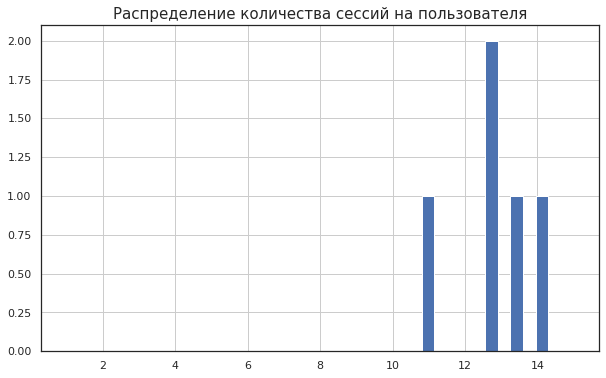

In [31]:
sessions_per_user['sessions_per_user'].hist(bins=40, range=(1,15))
plt.title('Распределение количества сессий на пользователя', fontsize=15)
plt.show()

In [32]:
print('Среднее количество сессий одного пользователя в неделю:', 
      sessions_per_user['sessions_per_user'].mean())
print('Медианное количество сессий одного пользователя в неделю:', 
      sessions_per_user['sessions_per_user'].median())

Среднее количество сессий одного пользователя в неделю: 12.73
Медианное количество сессий одного пользователя в неделю: 12.74


Наибольшее число сессий наблюдается в период с 21 по 27 октября. Среднее количество сессий одного пользователя в неделю 12.73, из чего можно сделать вывод, что пользователи заходят в приложение 1-2 раза в день. 

Рассмотрим все виды событий, как часто они встречаются, отсортируем их по частоте.

In [33]:
events_count = data['event_name'].value_counts().to_frame()
events_count

,event_name
tips_show,40055
photos_show,10012
advert_open,6164
contacts_show,4450
map,3881
search_1,3506
favorites_add,1417
search_5,1049
tips_click,814
search_4,701


Объединим одинаковые по смыслу события contacts_show и show_contacts.

In [34]:
data['event_name'] = data['event_name'].str.replace('show_contacts','contacts_show')

Также соберем в общий поиск разные действия, связанные с поиском по сайту.

In [35]:
def search(x):
    if 'search' in x:
        return 'search'
    else:
        return x
    
data['event_name'] = data['event_name'].map(search)

Посмотрим сколько и каких событий совершают пользователи:

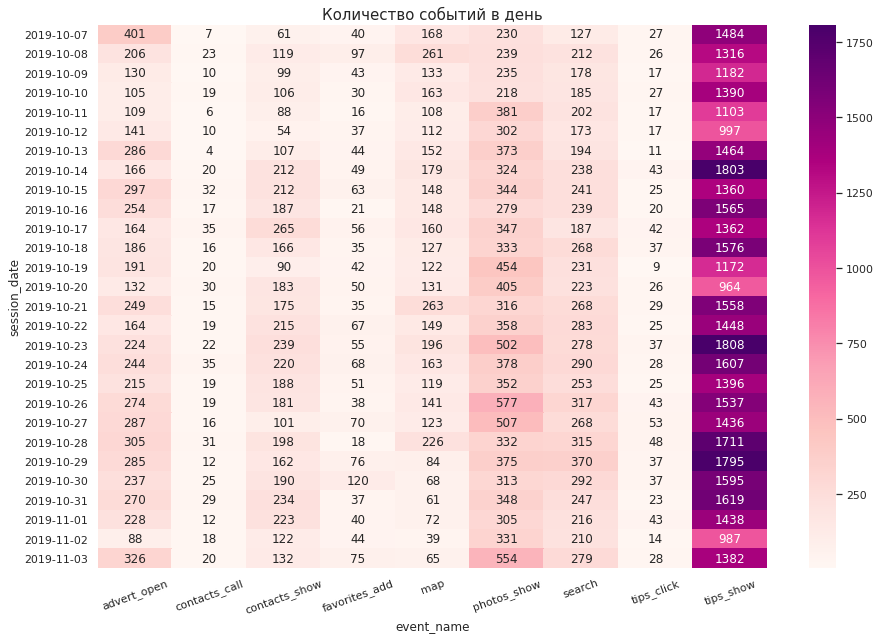

In [36]:
event_pivot = data.pivot_table(index='session_date', 
                               columns='event_name', 
                               values='event_time', 
                               aggfunc='count')
plt.figure(figsize=(15,10))
sns.heatmap(event_pivot, annot=True, fmt='', cmap='RdPu')
plt.title('Количество событий в день', fontsize=15)
plt.xticks(rotation=20) 
plt.show()

Чаще всего пользователи видят рекомендованные объявления, просматривают фотографии, открывают карточки объявлений, просматривают контакты, используют карту, реже добавляют объявления в избранное, еще реже кликают по рекомендациям и звонят. Небольшое количество звонков можно объяснить тем, что пользователи не всегда звонят из приложения, это действие трудно залогировать, именно поэтому contacts_call не является целевым событием. Низкий показатель кликов по рекомендациям может говорить о том, что система некорректно их подбирает (предлагает товары несоответствующие запросу). Возможно приложение слишком увлекается платными поднятиями объявлений, отсюда предложения со старыми датами и неактуальные товары. Также стоит выяснить попадают ли в рекомендации аналоги и сопутствующие товары, если не попадают, внедрение таких рекомендаций может повысить интерес пользователей. Также можно попробовать рекомендовать не конкретные объявления, а категории товаров.

**Целевое событие (contacts_show)**

In [37]:
all_users = data.query('event_name == "contacts_show"').groupby('user_id')['event_name'].count()
all_users.describe().to_frame()

,event_name
count,981.000000
mean,4.616718
std,9.621611
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,137.000000


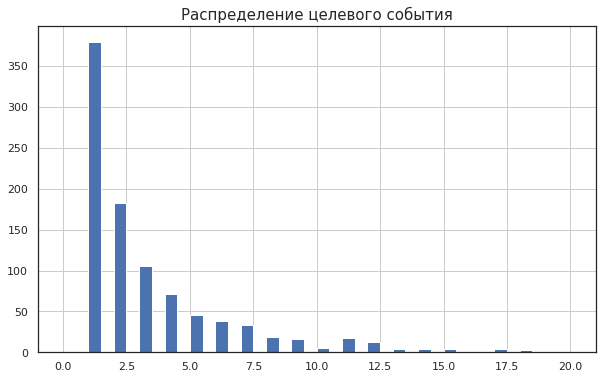

In [38]:
all_users.hist(bins=40, range=(0,20))
plt.title('Распределение целевого события', fontsize=15)
plt.show()

Общее число пользователей совершивших целевое событие 981.  
В среднем один пользователь совершает событие 4,6 раз.  
Минимально событие совершено 1 раз.   
Максимально событие совершено 137 раз.  

**Посмотрим, какие действия чаще совершают пользователи, которые просматривают контакты.**

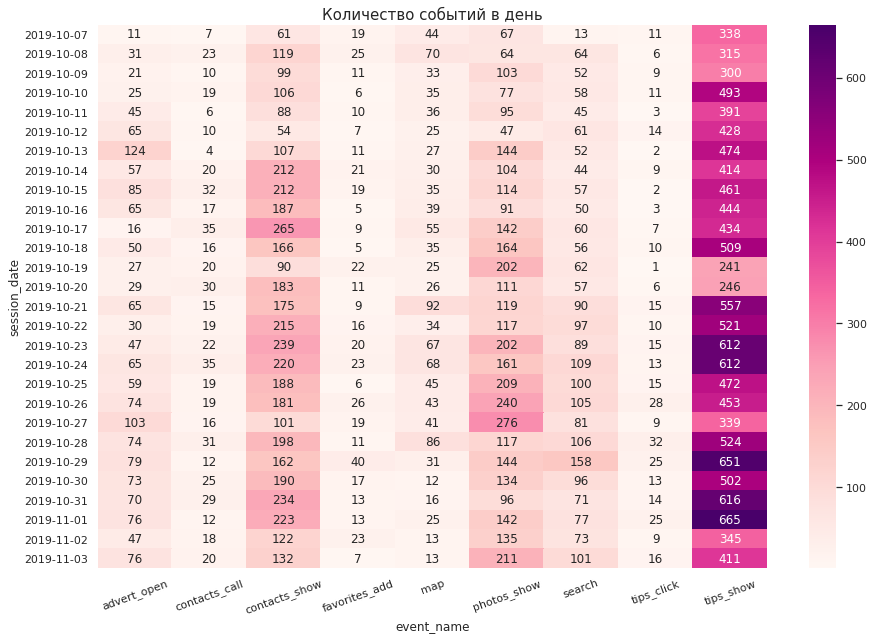

In [39]:
all_contacts_show = data.query('event_name == "contacts_show"')['user_id'].unique().tolist()
cs_data = data.query('user_id == @all_contacts_show')

cs_event_pivot = cs_data.pivot_table(index='session_date', 
                                     columns='event_name', 
                                     values='event_time', 
                                     aggfunc='count')
plt.figure(figsize=(15,10))
sns.heatmap(cs_event_pivot, annot=True, fmt='', cmap='RdPu')
plt.title('Количество событий в день', fontsize=15)
plt.xticks(rotation=20) 
plt.show()

Чаще всего пользователи совершившие целевое событие также как и пользователи целевое событие не совершившие видят рекомендованные объявления, просматривают фотографии, используют карту, открывают карточки объявлений, реже добавляют объявления в избранное, еще реже кликают по рекомендациям. Столбец contacts_call полностью повторяет одноименный столбец тепловой карты по всем данным, что означает отсутствие возможности совершить звонок без просмотра контактов, в этой части система работает корректно (аномалий нет). 

Для всех пользователей:

In [41]:
user_events_per_day = data.groupby(['session_date', 'event_name'])['event_time'].count().reset_index()
user_events_per_day.columns = ['session_date', 'event_name', 'n_events']
user_events_per_day['user_events_share'] = (user_events_per_day['n_events'] / data['user_id'].nunique())

events_pivot = user_events_per_day.pivot_table(index='session_date', 
                                        columns='event_name', 
                                        values='user_events_share', 
                                        aggfunc='mean')

Для пользователей просматривавших контакты:

In [42]:
cs_user_events_per_day = cs_data.groupby(['session_date', 'event_name'])['event_time'].count().reset_index()
cs_user_events_per_day.columns = ['session_date', 'event_name', 'n_events']
cs_user_events_per_day['user_events_share'] = (cs_user_events_per_day['n_events'] / data['user_id'].nunique())

cs_events_pivot = cs_user_events_per_day.pivot_table(index='session_date', 
                                                  columns='event_name', 
                                                  values='user_events_share', 
                                                  aggfunc='mean')

Сравним графики.

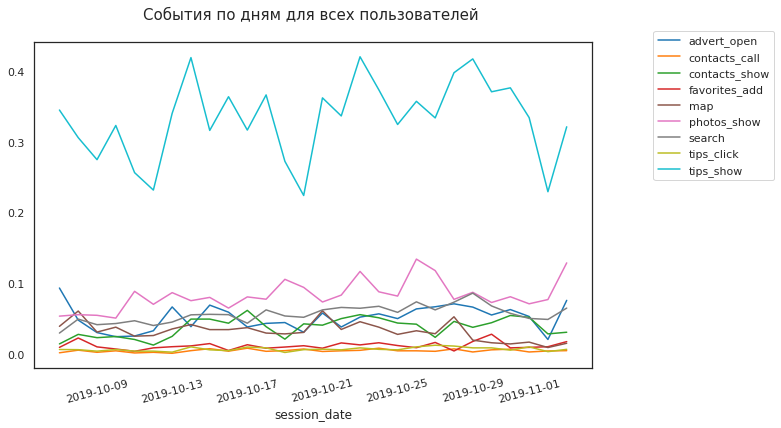

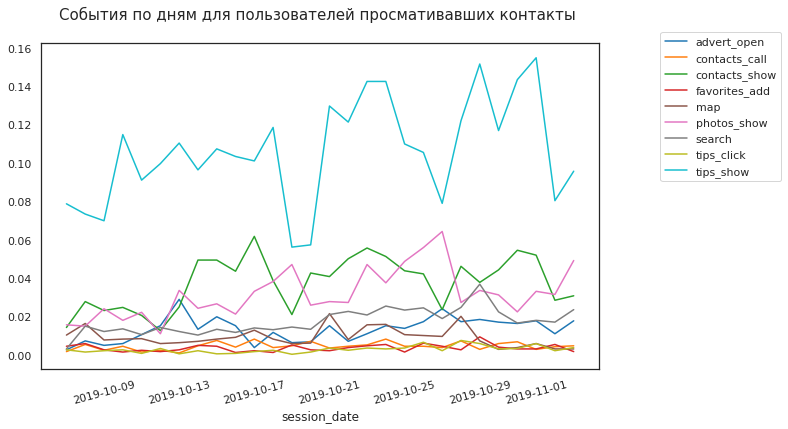

In [43]:
events_pivot.plot(cmap='tab10')
plt.title('События по дням для всех пользователей \n', fontsize=15)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=15) 
plt.show()

cs_events_pivot.plot(cmap='tab10')
plt.title('События по дням для пользователей просмативавших контакты \n', fontsize=15)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=15) 
plt.show()

Заметных изменений в открытии объявлений не наблюдается. Количество совершенных звонков не изменилось, избранное и использование карты почти без изменений. Пользователи просматривавшие контакты, чаще смотрели фотографии в объявлениях. Поиск и клики по рекомендациям без изменений. Наиболее ярким отличием является просмотр рекомендованных объявлений, похоже пользователи просматривавшие контакты видели меньше рекомендаций (особенно ярко это показывабют провалы на втором графике в районе 14, 19 и 26 октября). 

Выведем общее число событий за весь период, средние и медианные значения событий за день. 

In [44]:
n_events = data['event_name'].value_counts().reset_index()
n_events.columns = ['event_name', 'n_events']

mean_events_per_day = data.groupby(['session_date', 'event_name'])['event_time'].count().reset_index()
mean_events_per_day.columns = ['session_date', 'event_name', 'n_events']
mean_events_per_day = mean_events_per_day.groupby('event_name')['n_events'].agg(['mean', 'median']).round(1)
mean_events_per_day = mean_events_per_day.sort_values(by='mean', ascending=False).reset_index()
mean_events_per_day.columns = ['event_name', 'mean', 'median']
mean_events_per_day = n_events.merge(mean_events_per_day, on='event_name')

cs_mean_events_per_day = cs_data.groupby(['session_date', 'event_name'])['event_time'].count().reset_index()
cs_mean_events_per_day.columns = ['session_date', 'event_name', 'n_events']
cs_mean_events_per_day = cs_mean_events_per_day.groupby('event_name')['n_events'].agg(['mean', 'median']).round(1)
cs_mean_events_per_day = cs_mean_events_per_day.sort_values(by='mean', ascending=False).reset_index()
cs_mean_events_per_day.columns = ['event_name', 'cs_mean', 'cs_median']

mean_events_per_day = mean_events_per_day.merge(cs_mean_events_per_day, on='event_name')
mean_events_per_day

,event_name,n_events,mean,median,cs_mean,cs_median
0,tips_show,40055,1430.5,1443.0,456.0,457.0
1,photos_show,10012,357.6,345.5,136.7,126.5
2,search,6784,242.3,240.0,74.4,67.5
3,advert_open,6164,220.1,226.0,56.8,62.0
4,contacts_show,4529,161.8,178.0,161.8,178.0
5,map,3881,138.6,137.0,39.3,35.0
6,favorites_add,1417,50.6,44.0,15.1,13.0
7,tips_click,814,29.1,27.0,11.9,10.5
8,contacts_call,541,19.3,19.0,19.3,19.0


Средние и медианные значения различаются несильно, выбросов нет. 

### Расчет конверсии действий пользователей в целевое событие 

Найдем количество уникальных пользователей, совершающих каждое действие, далее среди них посчитаем количество пользователей просматривавших контакты. Зная эти данные определим конверсию в целевое действие. 

In [45]:
event_names = data['event_name'].unique().tolist()

users_list = []

for name in event_names:
    uniq_users = data.query('event_name == @name')['user_id'].unique().tolist()
    cs_uniq_users = data.query(
        'event_name == "contacts_show" and user_id.isin(@uniq_users)')['user_id'].unique().tolist()
    df_list = [name, len(uniq_users), len(cs_uniq_users), (len(cs_uniq_users) / len(uniq_users))]
    users_list.append(df_list)
    
cr_data = pd.DataFrame(users_list)
cr_data.columns = ['event_name', 'unique_users_count', 'cs_users_count', 'cr']
cr_data['cr'] = cr_data['cr'].round(2).apply(lambda x: f"{x:1.1%}")
cr_data.drop(labels = [3, 8],axis = 0, inplace = True)
cr_data.sort_values(by='cr', ascending=False)

,event_name,unique_users_count,cs_users_count,cr
7,favorites_add,351,136,39.0%
5,tips_click,322,100,31.0%
6,photos_show,1095,339,31.0%
4,search,1666,377,23.0%
2,map,1456,289,20.0%
0,advert_open,751,138,18.0%
1,tips_show,2801,516,18.0%


Наибольшую конверсию в целевое действие показали события: `favorites_add`, `tips_click` и `photos_show`, наименьшую - `tips_show` и `advert_open`. Вполне ожидаемый результат.  

**Вывод по разделу**

Наибольшее число пользователей пришло через yandex (1 934), гугл и другие источники идут практически вровень (1 129 и 1 230 соответственно). Больше всего сессий наблюдается в период с 21 по 27 октября, среднее количество сессий одного пользователя в неделю 12.73 (1-2 сессии в день).

Чаще всего пользователи видят рекомендованные объявления, просматривают фотографии, открывают карточки объявлений, просматривают контакты, используют карту, реже добавляют объявления в избранное, еще реже кликают по рекомендациям и звонят. Общее число пользователей совершивших целевое событие 981, в среднем один пользователь просматривает контакты от 1 до 4 раз. 

Наибольшую конверсию в целевое действие показали не самые популярные события: добавление в избранное и клик по рекомендации (из общего числа событий 74197: favorites_add всего 1417 событий, tips_click - 814). Наименьшую конверсию в просмотр контактов напротив имеет самое популярное событие tips_show (40055 из общего числа).

## Проверка гипотез

### Гипотеза №1

Одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`.  
Гипотеза: конверсия в просмотры контактов различается у этих двух групп.

In [46]:
tips_show = data.query('event_name == "tips_show"')['user_id'].unique()
tips_show_click = data.query('event_name == "tips_click" and user_id.isin(@tips_show)')['user_id'].unique()

print('Количество уникальных пользователей совершивших только tips_show:', len(tips_show))
print('Количество уникальных пользователей совершивших оба действия:', len(tips_show_click))

Количество уникальных пользователей совершивших только tips_show: 2801
Количество уникальных пользователей совершивших оба действия: 297


In [47]:
cs_tips_show = data.query('event_name == "contacts_show" and user_id.isin(@tips_show)')['user_id'].unique()
cs_tips_show_click = data.query(
    'event_name == "contacts_show" and user_id.isin(@tips_show_click)')['user_id'].unique()
tips_show_cr = (len(cs_tips_show) / len(tips_show))
tips_show_click_cr = (len(cs_tips_show_click) / len(tips_show_click))

print('Количество уникальных пользователей просматривавших контакты (tips_show):', len(cs_tips_show))
print('Количество уникальных пользователей просматривавших контакты (tips_show_click):', len(cs_tips_show_click))
print(f'Конверсия в просмотры контактов tips_show: {round(tips_show_cr*100, 2)}%')       
print(f'Конверсия в просмотры контактов tips_show_click: {round(tips_show_click_cr*100, 2)}%')   

Количество уникальных пользователей просматривавших контакты (tips_show): 516
Количество уникальных пользователей просматривавших контакты (tips_show_click): 91
Конверсия в просмотры контактов tips_show: 18.42%
Конверсия в просмотры контактов tips_show_click: 30.64%


Метод для проверки гипотезы - проверка гипотезы о равенстве долей (сравниваем доли уникальных пользователей совершивших целевое событие).

Гипотеза H₀: в конверсии в просмотры контактов между группами a и b нет статистически значимых различий.  
Гипотеза H₁: в конверсии в просмотры контактов между группами a и b есть статистически значимые различия.  

Данные для теста: 

In [48]:
alpha = .05 
successes = [len(cs_tips_show), len(cs_tips_show_click)] 
trials = [len(tips_show), len(tips_show_click)]

print(successes)
print(trials)

[516, 91]
[2801, 297]


In [49]:
def stat_test(successes, trials, alpha):  

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value:', round(p_value, 2))

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

stat_test(successes, trials, alpha)  

p-value: 0.0
Отвергаем нулевую гипотезу


С помощью функции stat_test проведено тестирование на равенство долей, где: successes - количество успешных попыток в группах, trials - всего попыток в группах, alpha - уровень статистической значимости. Считаем статистику в ст.отклонениях стандартного нормального распределения (z_value), в distr задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1). P-value меньше 0.05, нулевую гипотезу отвергаем, тем самым подтверждаем результаты полученные выше: конверсия в просмотры контактов у двух групп различается.

### Гипотеза №2

Одни пользователи пришли в приложение через `yandex`, другие через `google`.  
Гипотеза: конверсия в просмотры контактов различается у этих двух групп.

In [50]:
yandex = data.query('source == "yandex"')['user_id'].unique()
google = data.query('source == "google"')['user_id'].unique()

print('Количество уникальных yandex-пользователей:',len(yandex))
print('Количество уникальных google-пользователей:', len(google))

Количество уникальных yandex-пользователей: 1934
Количество уникальных google-пользователей: 1129


In [51]:
cs_yandex = data.query('event_name == "contacts_show" and user_id.isin(@yandex)')['user_id'].unique()
cs_google = data.query('event_name == "contacts_show" and user_id.isin(@google)')['user_id'].unique()
yandex_cr = (len(cs_yandex) / len(yandex))
google_cr = (len(cs_google) / len(google))

print('Количество уникальных yandex-пользователей просматривавших контакты:', len(cs_yandex))
print('Количество уникальных google-пользователей просматривавших контакты:', len(cs_google))
print(f'Конверсия в просмотры контактов yandex: {round(yandex_cr*100, 2)}%')       
print(f'Конверсия в просмотры контактов google: {round(google_cr*100, 2)}%')   

Количество уникальных yandex-пользователей просматривавших контакты: 478
Количество уникальных google-пользователей просматривавших контакты: 275
Конверсия в просмотры контактов yandex: 24.72%
Конверсия в просмотры контактов google: 24.36%


Гипотеза H₀: в конверсии в просмотры контактов между группами yandex- и google-пользователей нет статистически значимых различий.  
Гипотеза H₁: в конверсии в просмотры контактов между группами yandex- и google-пользователей есть статистически значимые различия.  

Данные для теста:

In [52]:
alpha = .05 
successes = [len(cs_yandex), len(cs_google)] 
trials = [len(yandex), len(google)]

print(successes)
print(trials)

[478, 275]
[1934, 1129]


In [53]:
stat_test(successes, trials, alpha)

p-value: 0.82
Не получилось отвергнуть нулевую гипотезу


P-value превышает уровень статистической значимости, отвергнуть нулевую гипотезу не получилось. Можем сделать вывод, что пользователи из источников yandex и google просматривают контакты с одинаковой частотой. 

**Вывод по разделу**

Гипотеза о различии конверсии в просмотр контактов у пользователей совершивших действия tips_show и tips_click и у пользователей совершивших только tips_show подтвердилась. Конверсия "просмотр + клик" значительно выше.   

Гипотеза о различии конверсии в просмотр контактов у пользователей из yandex и google не подтвердилась. Показатели конверсии оказались практически равны. 

## Выводы и рекомендации

**Качество данных**  
  
В данных не обнаружено пропусков и дубликатов.   
В дальнейшем будет полезно также фиксировать время начала и окончания сессий, также было бы интересно исследовать более продолжительный период.   

**Активность пользователей**    

Расчет метрик DAU/WAU позволил выдвинуть предположение о наличии сезонной активности пользователей. Однако рассчитав коэффициент удержания мы обнаружили, что на вторую неделю жизни с нами остается только 23.4% пользователей. Снижение может быть вызвано как техническими проблемами, так и неудовлетворением спроса пользователей.

**Исследовательский анализ данных**    

Общее число уникальных пользователей: 4 293.    
Источники: yandex (1 934), other (1 230), google (1 129).  
  
Наибольшее число сессий наблюдается в период с 21 по 27 октября, среднее количество сессий одного пользователя в неделю 12.73 (1-2 сессии в день).    

Общее число пользователей просматривавших контакты 981, в среднем один такой пользователь совершает целевое действие от 1 до 4 раз.   

Общее число событий: 74 197.    
Виды и частатота: tips_show 40 055, photos_show 10 012, search 6 784, advert_open 6 164, contacts_show 4 529, map 3 881, favorites_add 1 417, tips_click 814, contacts_call 541.    

Конверсия в целевое действие: favorites_add	(39.0%), tips_click	(31.0%), photos_show (31.0%), search (23.0%) map (20.0%), advert_open (18.0%), tips_show (18.0%).

Наибольшую конверсию в целевое действие показали не самые популярные события: добавление в избранное и клик по рекомендации (из общего числа событий 74 197: favorites_add всего 1417 событий, tips_click - 814). Наименьшую конверсию в просмотр контактов напротив имеет самое популярное событие tips_show (40 055 из общего числа).
  
**Гипотезы**  
  
Гипотеза о различии конверсии в просмотр контактов у пользователей совершивших действия tips_show и tips_click и у пользователей совершивших только tips_show подтвердилась. Конверсия "просмотр + клик" значительно выше. Еще один повод поработать над качеством рекомендаций. 

Гипотеза о различии конверсии в просмотр контактов у пользователей из yandex и google не подтвердилась. В данном случае источник в связке с целевым действием не имеет значения. 
  
**Рекомендации**  
  
1. В первую очередь нужно работать с tips_show, есть предположение, что рекомендации сейчас слишком навязчивые. Также необходимо разобраться на чем основана выдача объявлений. Подбор рекомендуемых объявлений должен учитывать: историю действий пользователей в приложении (просмотры, поисковые запросы, контакты, избранное), профили пользователей (данные из привязанных аккаунтов соц. сетей, локация), все активные объявления в приложении: заголовок, описание, параметры, цена. Возможно сейчас система тупо показывает самые новые объявления. Также стоит выяснить попадают ли в рекомендации аналоги и сопутствующие товары, если не попадают, внедрение таких рекомендаций может повысить интерес пользователей. Также можно попробовать рекомендовать не конкретные объявления, а категории товаров.   

  
2. Необходимо работать с favorites_add, «избранное» может быть эффективным инструментом, если его функционал выстроен верно и заточен под последующую продажу. Это определенно точка роста.      

  
3. Также есть вариант повышения качества рекомендаций за счет повышения качества самих объявлений. Например, внедрение системы push-уведомлений для продавцов с советами по улучшению качества предложения (как сделать хорошие фотографии, подобрать ключевые слова, адекватно оценить стоимость).  